In [170]:
import sys
import sklearn
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [171]:
data = pd.read_csv('creditcard.csv')

In [172]:
print(data.columns)
print(data.shape)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
(284807, 31)


In [173]:
print(data.describe)

<bound method NDFrame.describe of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
5            2.0  -0.425966   0.960523  1.141109 -0.168252  0.420987   
6            4.0   1.229658   0.141004  0.045371  1.202613  0.191881   
7            7.0  -0.644269   1.417964  1.074380 -0.492199  0.948934   
8            7.0  -0.894286   0.286157 -0.113192 -0.271526  2.669599   
9            9.0  -0.338262   1.119593  1.044367 -0.222187  0.499361   
10          10.0   1.449044  -1.176339  0.913860 -1.375667 -1.971383   
11          10.0   0.384978   0.616109 -0.874300 -0.094019  2.924584   
12          10.0   1.249999  -

In [174]:
data = data.sample(frac =0.3,random_state=1)
print(data.describe)

<bound method NDFrame.describe of             Time        V1        V2        V3        V4        V5        V6  \
169876  119907.0 -0.611712 -0.769705 -0.149759 -0.224877  2.028577 -2.019887   
127467   78340.0 -0.814682  1.319219  1.329415  0.027273 -0.284871 -0.653985   
137900   82382.0 -0.318193  1.118618  0.969864 -0.127052  0.569563 -0.532484   
21513    31717.0 -1.328271  1.018378  1.775426 -1.574193 -0.117696 -0.457733   
134700   80923.0  1.276712  0.617120 -0.578014  0.879173  0.061706 -1.472002   
196117  131364.0  0.077197  0.482928 -2.234233 -1.309124  2.386570  3.392581   
24533    33274.0 -0.958584  1.109086  1.558159  0.878707  1.914559  1.564757   
13629    24158.0 -0.992899  1.430204  1.071256  1.363127  0.116315  0.217868   
246673  153276.0 -1.143693 -0.250983  1.013022 -0.671080  1.363438  0.312673   
91842    63649.0  0.555043 -0.099484 -0.102234 -0.624145  1.484364  4.154536   
33014    37056.0  0.884282 -0.973495  0.929080  0.397955 -1.463564 -0.351713   
14195 

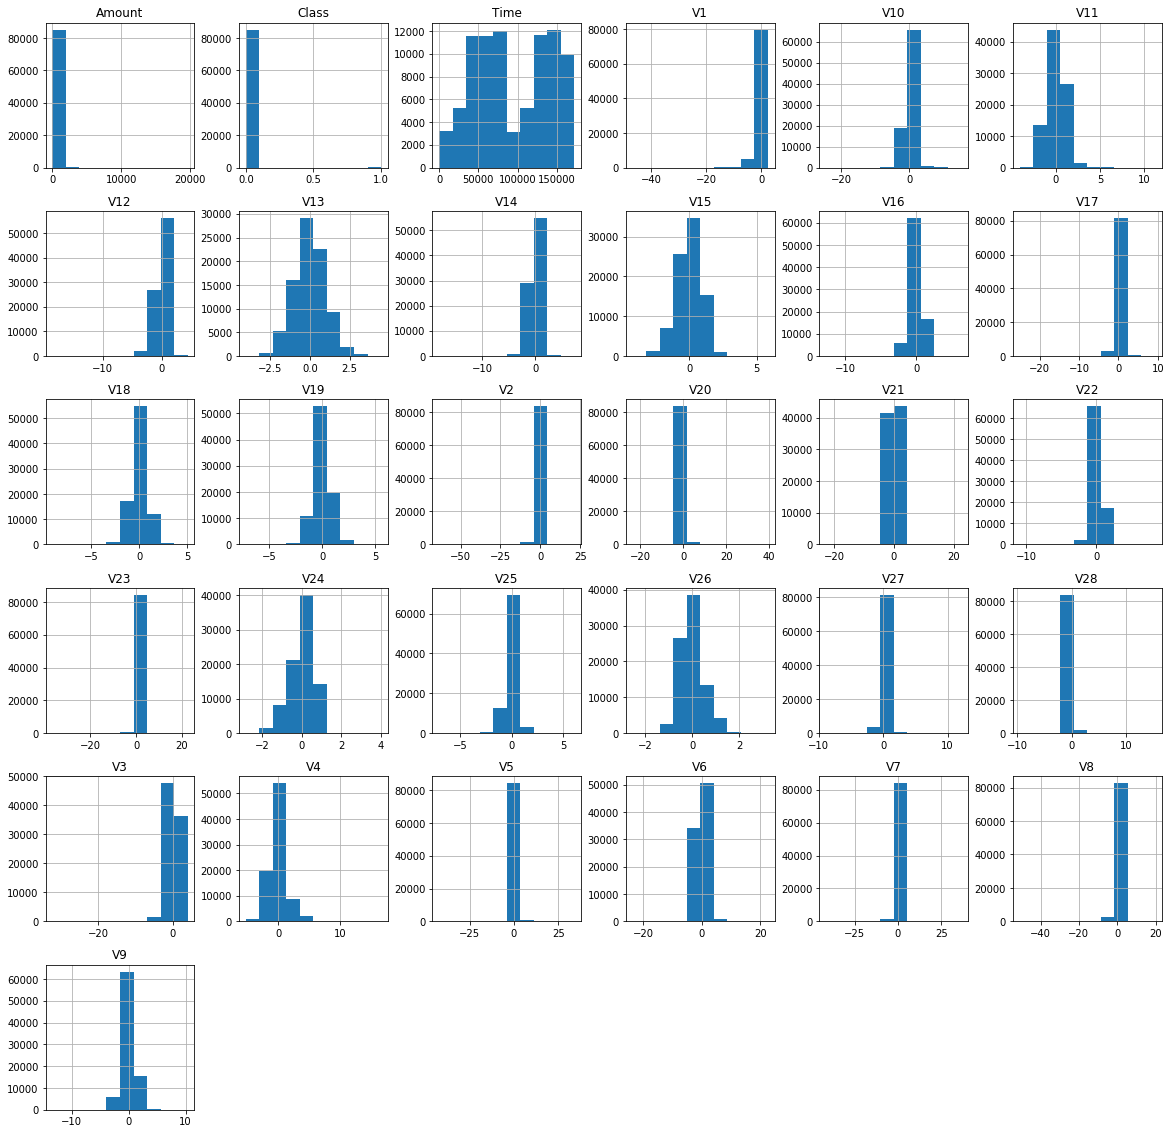

In [175]:
data.hist(figsize=(20,20))
plt.show()

In [176]:
fraud = data[data['Class']==1]
valid = data[data['Class']==0]

outlier_fract = len(fraud)/float(len(valid))

print(outlier_fract)

print('Fraud cases: {}'.format(len(fraud)))

print('Valid cases: {}'.format(len(valid)))


0.001582519605659559
Fraud cases: 135
Valid cases: 85307


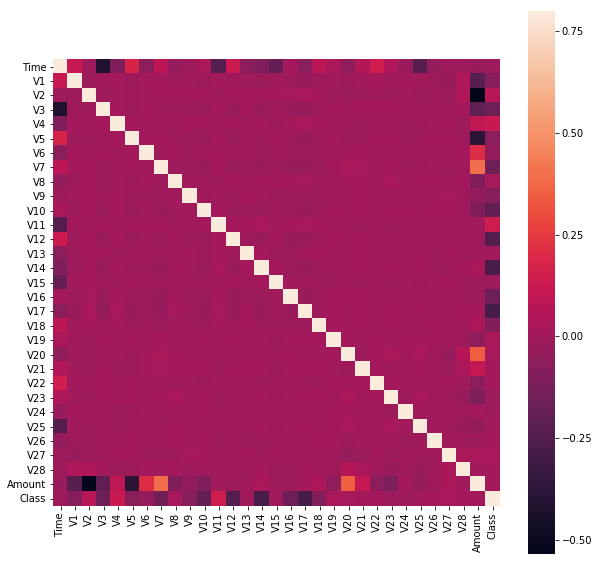

In [177]:
corr_mat = data.corr() #to see strong correlation in the data

fig = plt.figure(figsize = (10,10))

sns.heatmap(corr_mat, vmax =0.8, square = True) # for nice visual 
plt.show()

In [178]:
columns = data.columns.tolist()

columns = [c for c in columns if c not in ['Class']] #to remove data we don't want
target = 'Class'
X = data[columns]
Y = data[target]

print(X.shape)
print(Y.shape)



(85442, 30)
(85442,)


In [179]:
from sklearn.metrics import classification_report, accuracy_score #to determine how successful we are in our outlier detection
from sklearn.ensemble import IsolationForest  #combination of random forest tree and isolate the observation to calculate the anomaly score
from sklearn.neighbors import LocalOutlierFactor #similar to k nearest neighbor algo.It measures local deviaton density of the given sample with respect to its neighbour  


In [180]:
state = 1 #random state

# define the outlier definition methods
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                       contamination = outlier_fract,
                                       random_state = state),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors = 20,
                                               contamination = outlier_fract)
}


In [181]:
n_outliers = len(fraud)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    print('{} : {}'.format(clf_name, n_errors))
    
    print(accuracy_score(Y,y_pred))
    print(classification_report(Y,y_pred))


Isolation Forest : 191
0.9977645654362023
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85307
          1       0.29      0.30      0.30       135

avg / total       1.00      1.00      1.00     85442

Local Outlier Factor : 263
0.9969218885325718
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85307
          1       0.03      0.03      0.03       135

avg / total       1.00      1.00      1.00     85442

